# Explore `meta-kaggle` Dataset

## --- Test Synthetically Generated Data

We test the potential of our estimation algorithm by synthetically generated data.

In [ ]:
# std library
import os
import json
from pprint import pprint
from datetime import datetime, timedelta
from typing import Sequence

# third-party
from matplotlib import pyplot as plt
import numpy as np
from numpy import typing as npt
import cmdstanpy
cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

# local
import synthetic.synthetic_data as dgp
import synthetic.ryvkin_model as ryvkin_model

CmdStan install directory: /Users/zhuanglinsheng/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


### 1. Model Setting

In [2]:
# Capacities & Total Innovation Uncertainty
## Hour based
param_c_i = 0.15
param_c_j = 0.15
param_sigma = 1.0

# Contest related
param_theta = 1

# Signal Precision
param_lambda = 1

# Intensity-Effort Ratio
param_r = 2

# Contest Time Duaration
time_step = 1 / 24
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timegrids = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=np.datetime64)

print(contest_days, contest_hours, len(contest_timegrids))

90 2160 2160


### 2. Simulations

In [3]:
time_grids, i_effort_dynamic, j_effort_dynamic, \
real_gap_dynamic, perceived_gap_dynamic, observed_gap_dynamic, \
observed_i_commits, observed_j_commits = dgp.synthetic_data_simulation(
	c_i=param_c_i,
	c_j=param_c_j,
	theta=param_theta,
	sigma=param_sigma,
	lamb=param_lambda,
	r=param_r,
	hour_arrival_ub=1,
	start_time=start_time,
	end_time=end_time,
	time_unit=timedelta(hours=1),
	time_unit_2f=time_step,
)

In [4]:
def plot_ts_events(
		time_grids: Sequence[datetime] | npt.NDArray[np.datetime64],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		*,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios
	)
	# plot time series
	for ts_key, ts_val in ts.items():
		ax_main.plot(time_grids, ts_val, label=ts_key)
	ax_main.legend()
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1])
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height)
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

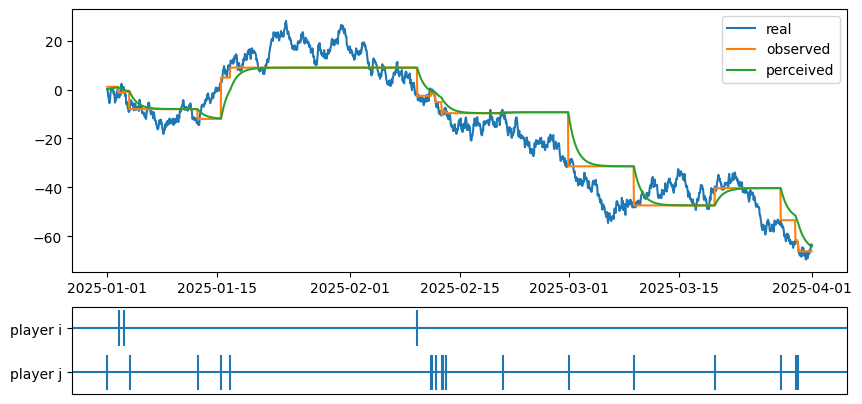

In [5]:
fig, _, _ = plot_ts_events(time_grids, {
			'real': real_gap_dynamic,
			'observed': observed_gap_dynamic,
			'perceived': perceived_gap_dynamic,
		}, {
			'player i': observed_i_commits,
			'player j': observed_j_commits,
	})

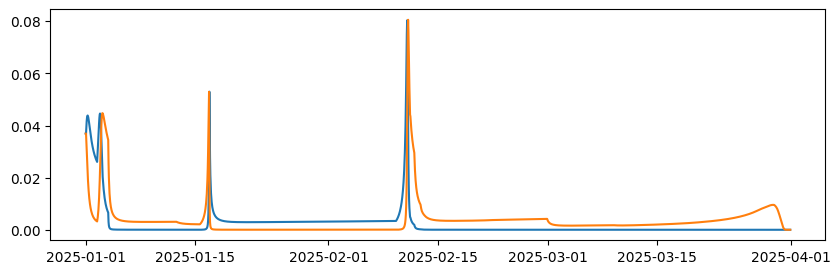

In [6]:
plt.figure(figsize=(10, 3))
plt.plot(time_grids, i_effort_dynamic)
plt.plot(time_grids, j_effort_dynamic)
plt.show()

In [10]:
# save the observed data
wd = os.getcwd()
wd_synthetic_data = os.path.join(wd, 'synthetic', 'data.json')

with open(wd_synthetic_data, 'w') as f:
	json.dump({
		'observed_i_commits': [dt.isoformat() for dt in observed_i_commits],
		'observed_j_commits': [dt.isoformat() for dt in observed_j_commits],
		'observed_gap_dynamic': observed_gap_dynamic.tolist(),
	}, f, indent=4)

### 3. Bayesian Inference